In [1]:

import os
import datetime
import numpy as np
import tensorflow as tf
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
import time


In [2]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu, dropout = True, keep_prob=1.0):
    with tf.device('/cpu:0'):
        weights = tf.Variable(
            tf.truncated_normal(
                [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
            'weights')
        biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = tf.nn.dropout(nonlinearity(tf.matmul(inputs, weights) + biases), keep_prob)
    return outputs

def fully_bn_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu, dropout = True, keep_prob=1.0, train=True):
    with tf.device('/cpu:0'):
        weights = tf.Variable(
            tf.truncated_normal(
                [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
            'weights')
        z_BN = tf.matmul(inputs,weights)
        BN = tf.contrib.layers.batch_norm(z_BN, center=True, scale=True,
                                                 is_training=train)
    outputs = tf.nn.dropout(nonlinearity(BN), keep_prob)
    return outputs

def _variable_with_weight_decay(name, shape, stddev, wd):
    var = tf.get_variable(name, shape, initializer=tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32),dtype=tf.float32)
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

In [3]:
   
def conv_bn_layer1(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu, dropout = True, keep_prob=1.0,train=True):
    kernel = _variable_with_weight_decay('weights1',
                                         shape=[5, 5, 3, 64],
                                         stddev=5e-2,
                                         wd=0.0001)
    reshape = tf.reshape(inputs, [50,32,32,3])
    conv = tf.nn.conv2d(reshape, kernel, [1, 1, 1, 1], padding='SAME')
    BN2 = tf.contrib.layers.batch_norm(conv, center=True, scale=True,
                                                 is_training=train)
    outputs = tf.nn.dropout(nonlinearity(BN), keep_prob)
    return outputs

def conv_bn_layer2(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu, dropout = True, keep_prob=1.0,train=True):
    kernel = _variable_with_weight_decay('weights1',
                                         shape=[5, 5, 3, 64],
                                         stddev=5e-2,
                                         wd=0.0001)
    reshape = tf.reshape(inputs, [50,32,32,3])
    conv = tf.nn.conv2d(reshape, kernel, [1, 1, 1, 1], padding='SAME')
    BN2 = tf.contrib.layers.batch_norm(conv, center=True, scale=True,
                                                 is_training=train)
    outputs = tf.nn.dropout(nonlinearity(BN), keep_prob)
    return outputs

In [4]:
random_seed = 1627522
rng = np.random.RandomState(random_seed)

train_data = CIFAR10DataProvider('train', batch_size=50, rng=rng)
valid_data = CIFAR10DataProvider('valid', batch_size=50, rng=rng)

In [5]:
inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
keep_prob=tf.placeholder(tf.float32)
train=tf.placeholder(bool)

with tf.variable_scope('conv1') as scope:
    inputs_new=tf.reshape(inputs,[50,32,32,3])
    kernel1 = _variable_with_weight_decay('conv_weights_1', shape=[3, 3, 3, 128], stddev=5e-2, wd=0.0)
    conv = tf.nn.conv2d(inputs_new, kernel1, [1, 1, 1, 1], padding='SAME')
    biases1 = tf.get_variable('biases2', [128], initializer=tf.constant_initializer(0.0), dtype=tf.float32)
    pre_activation1 = tf.nn.bias_add(conv, biases1)
    conv1 = tf.nn.relu(pre_activation1, name=scope.name)

# pool1
pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                         padding='SAME', name='pool1')
# norm1
norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm1')

# conv2
with tf.variable_scope('conv2') as scope:
    kernel2 = _variable_with_weight_decay('conv_weights_2', shape=[3, 3, 128, 128], stddev=5e-2, wd=0.0)
    conv_2 = tf.nn.conv2d(norm1, kernel2, [1, 1, 1, 1], padding='SAME')
    biases2 = tf.get_variable('biases2', [128], initializer=tf.constant_initializer(0.1), dtype=tf.float32)
    pre_activation2 = tf.nn.bias_add(conv_2, biases2)
    conv2 = tf.nn.relu(pre_activation2, name=scope.name)
    #_activation_summary(conv2)

# norm2
norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm2')
# pool2
pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1],
                         strides=[1, 2, 2, 1], padding='SAME', name='pool2')

# local3
with tf.variable_scope('local3') as scope:
    # Move everything into depth so we can perform a single matrix multiply.
    reshape = tf.reshape(pool2, [50,-1])
    hidden_1 = fully_connected_layer(reshape, 8192, 1000, keep_prob=1.0)

# local4
with tf.variable_scope('local4') as scope:
    outputs = fully_connected_layer(hidden_1, 1000, train_data.num_classes, tf.identity, keep_prob=1.0)
    
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.MomentumOptimizer(learning_rate=0.001,momentum=0.9).minimize(error)
    

In [6]:
init = tf.global_variables_initializer()


train_data.reset()
valid_data.reset()
running_error_one = []
running_accuracy_one = []
valid_error_one = []
valid_accuracy_one = []

with tf.Session() as sess:
    sess.run(init)
    for e in range(50):
        running_error = 0.
        running_accuracy = 0.
        start_time = time.time()
        for input_batch, target_batch in train_data:
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch, keep_prob:1.0, train: True})
            running_error += batch_error
            running_accuracy += batch_acc
        epoch_time = time.time() - start_time
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        
        running_error_one.append(running_error)
        running_accuracy_one.append(running_accuracy)
        
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f} epoch time={3:.2f}'
              .format(e + 1, running_error, running_accuracy, epoch_time))
        
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch, keep_prob:1.0, train: False})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
            
        valid_error_one.append(valid_error)
        valid_accuracy_one.append(valid_accuracy)
            
        print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                .format(valid_error, valid_accuracy))


End of epoch 01: err(train)=1.91 acc(train)=0.31 epoch time=361.25
                 err(valid)=1.65 acc(valid)=0.39
End of epoch 02: err(train)=1.57 acc(train)=0.44 epoch time=361.19
                 err(valid)=1.53 acc(valid)=0.46
End of epoch 03: err(train)=1.45 acc(train)=0.49 epoch time=363.35
                 err(valid)=1.42 acc(valid)=0.49
End of epoch 04: err(train)=1.36 acc(train)=0.52 epoch time=358.41
                 err(valid)=1.34 acc(valid)=0.53
End of epoch 05: err(train)=1.29 acc(train)=0.55 epoch time=358.03
                 err(valid)=1.27 acc(valid)=0.56
End of epoch 06: err(train)=1.24 acc(train)=0.57 epoch time=357.51
                 err(valid)=1.22 acc(valid)=0.57
End of epoch 07: err(train)=1.18 acc(train)=0.59 epoch time=357.34
                 err(valid)=1.18 acc(valid)=0.59
End of epoch 08: err(train)=1.13 acc(train)=0.61 epoch time=356.98
                 err(valid)=1.18 acc(valid)=0.59
End of epoch 09: err(train)=1.08 acc(train)=0.62 epoch time=357.34
     

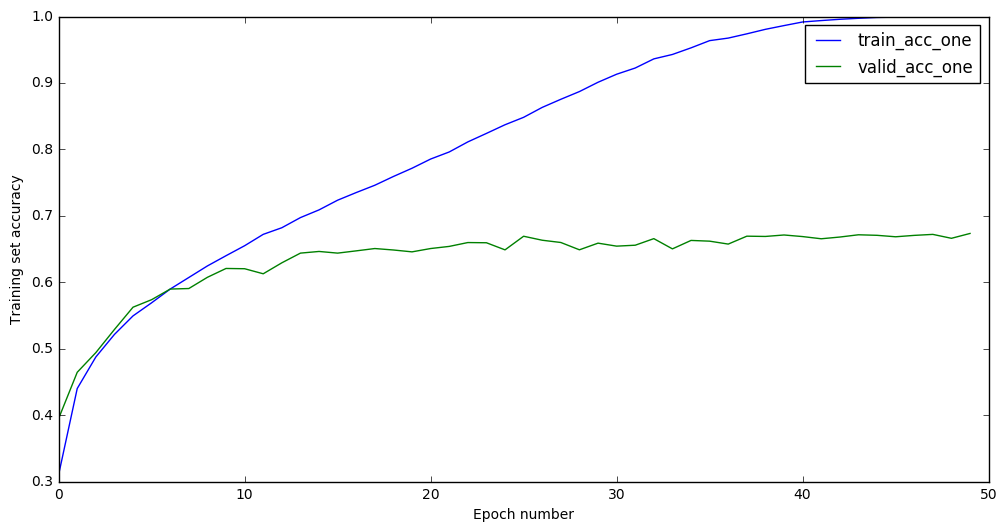

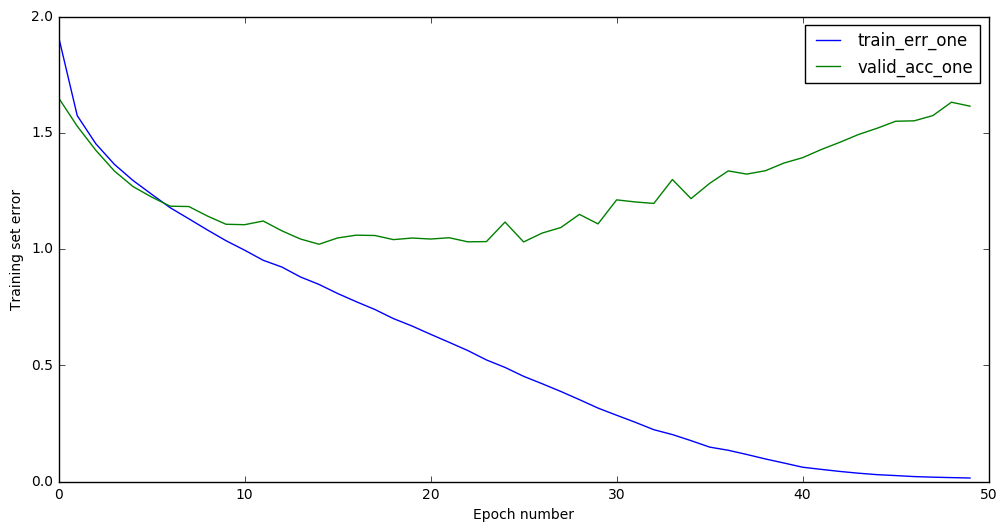

In [7]:

fig_1 = plt.figure(figsize=(12, 6))
ax1 = fig_1.add_subplot(111)
ax1.plot(running_accuracy_one, label = 'train_acc_one')
ax1.plot(valid_accuracy_one, label = 'valid_acc_one')
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set accuracy')

fig_2 = plt.figure(figsize=(12, 6))
ax2 = fig_2.add_subplot(111)
ax2.plot(running_error_one, label = 'train_err_one')
ax2.plot(valid_error_one, label = 'valid_acc_one')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Training set error')

fig_1.savefig('1.png')
fig_2.savefig('2.png')
plt.show()